# Data Understanding Phase

In [1]:
# Import necessary PySpark modules
import findspark
findspark.init('/home/ubuntu/spark-3.2.1-bin-hadoop2.7')
import pyspark
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.sql.types import StringType
from pyspark.sql.functions import isnan, when, count, col, round
from pyspark.ml.feature import VectorAssembler

In [2]:
# Create a Spark session
spark = SparkSession.builder.appName('StudentDataAnalysis').getOrCreate()

# Load the CSV file into a PySpark DataFrame
file_path = 'Datasets/student-por.csv'
student_por = spark.read.csv(file_path, header=True, inferSchema=True)

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/10/17 14:07:04 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
# Display the schema of the DataFrame
student_por.printSchema()

root
 |-- school: string (nullable = true)
 |-- sex: string (nullable = true)
 |-- age: integer (nullable = true)
 |-- address: string (nullable = true)
 |-- famsize: string (nullable = true)
 |-- Pstatus: string (nullable = true)
 |-- Medu: integer (nullable = true)
 |-- Fedu: integer (nullable = true)
 |-- Mjob: string (nullable = true)
 |-- Fjob: string (nullable = true)
 |-- reason: string (nullable = true)
 |-- guardian: string (nullable = true)
 |-- traveltime: integer (nullable = true)
 |-- studytime: integer (nullable = true)
 |-- failures: integer (nullable = true)
 |-- schoolsup: string (nullable = true)
 |-- famsup: string (nullable = true)
 |-- paid: string (nullable = true)
 |-- activities: string (nullable = true)
 |-- nursery: string (nullable = true)
 |-- higher: string (nullable = true)
 |-- internet: string (nullable = true)
 |-- romantic: string (nullable = true)
 |-- famrel: integer (nullable = true)
 |-- freetime: integer (nullable = true)
 |-- goout: integer (null

In [4]:
# Display the shape of the DataFrame
print("The shape of the data is: ({0},{1})".format(student_por.count(),len(student_por.columns)))
student_por.limit(5).toPandas()

The shape of the data is: (649,33)


23/10/17 14:07:17 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,4,0,11,11
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,2,9,11,11
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,6,12,13,12
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,0,14,14,14
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,0,11,13,13


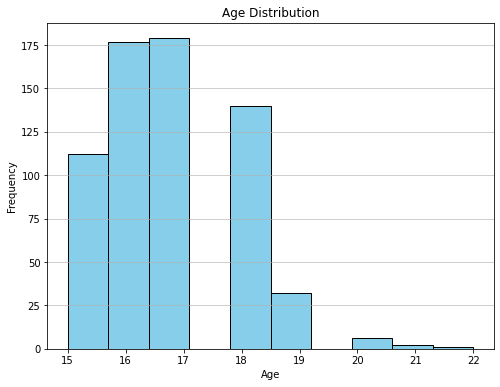

In [5]:
# Collect the 'age' column from the DataFrame and convert it to a list
age_data = student_por.select('age').rdd.flatMap(lambda x: x).collect()

# Create a histogram for the age distribution
plt.figure(figsize=(8, 6))
plt.hist(age_data, bins=10, color='skyblue', edgecolor='black')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Age Distribution')
plt.grid(axis='y', alpha=0.75)
plt.show()


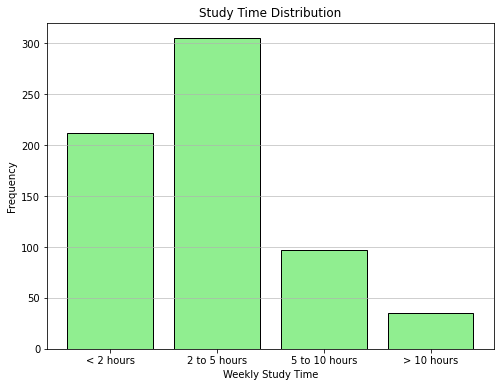

In [6]:
# Create a histogram for the study time distribution
studytime_histogram = student_por.groupBy("studytime").count().orderBy("studytime")
studytime_levels = studytime_histogram.rdd.map(lambda x: x[0]).collect()
studytime_counts = studytime_histogram.rdd.map(lambda x: x[1]).collect()

plt.figure(figsize=(8, 6))
plt.bar(studytime_levels, studytime_counts, color='lightgreen', edgecolor='black')
plt.xlabel('Weekly Study Time')
plt.ylabel('Frequency')
plt.title('Study Time Distribution')
plt.grid(axis='y', alpha=0.75)
plt.xticks(studytime_levels, ['< 2 hours', '2 to 5 hours', '5 to 10 hours', '> 10 hours'])
plt.show()

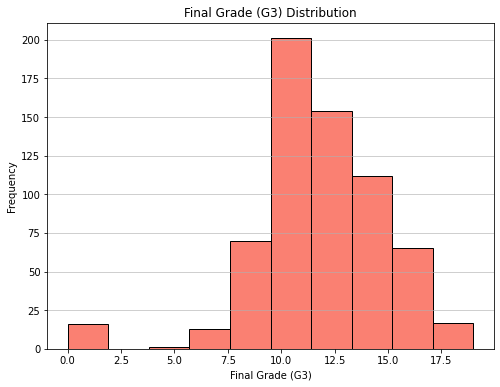

In [7]:
# Collect the 'G3' column from the DataFrame and convert it to a list
final_grade_data = student_por.select('G3').rdd.flatMap(lambda x: x).collect()

# Create a histogram for the final grade (G3) distribution
plt.figure(figsize=(8, 6))
plt.hist(final_grade_data, bins=10, color='salmon', edgecolor='black')
plt.xlabel('Final Grade (G3)')
plt.ylabel('Frequency')
plt.title('Final Grade (G3) Distribution')
plt.grid(axis='y', alpha=0.75)
plt.show()

In [8]:
# Check for missing values
missing_values = student_por.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in student_por.columns])

# Calculate total missing values
total_missing_values = missing_values.agg(*[count(when(col(c) > 0, c)).alias(c) for c in student_por.columns])

# Check completeness
completeness_dict = total_missing_values.first().asDict()
if not any(completeness_dict.values()):
    print("Completeness: Our dataset has no missing entries, ensuring 100% completeness across all fields and records.")
else:
    print("Completeness: There are missing entries in the dataset.")
    print(total_missing_values.show())

# Check for null values
null_counts = student_por.select([count(when(col(c).isNull(), c)).alias(c) for c in student_por.columns])

# Print columns with null values and their respective counts
columns_with_null_values = null_counts.toPandas().melt(var_name='Column', value_name='Missing Count')

if columns_with_null_values['Missing Count'].max() == 0:
    print("No null values found in the dataset.")
else:
    print("Columns with null values:")
    print(columns_with_null_values[columns_with_null_values['Missing Count'] > 0])


Completeness: Our dataset has no missing entries, ensuring 100% completeness across all fields and records.
No null values found in the dataset.


# Data Preparation Phase

In [9]:
# Drop the specified columns
columns_to_drop = ['school', 'reason', 'guardian']
student_por = student_por.drop(*columns_to_drop)

# Display the remaining columns
remaining_columns = student_por.columns
column_count = len(remaining_columns)

print("Remaining columns:")
print(remaining_columns)
print(f"Total number of remaining columns: {column_count}")

Remaining columns:
['sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu', 'Mjob', 'Fjob', 'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences', 'G1', 'G2', 'G3']
Total number of remaining columns: 30


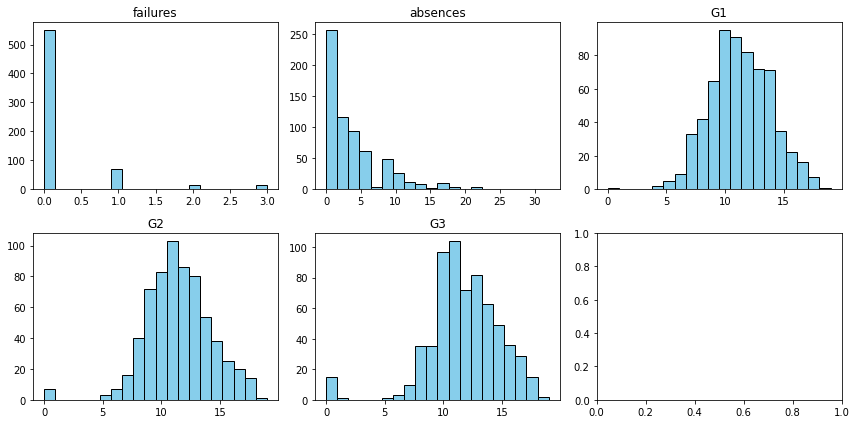

In [10]:
# Select the columns with outliers to create histograms
columns = ['failures', 'absences', 'G1', 'G2', 'G3']

# Collect data from PySpark DataFrame to Python lists
data = {col: student_por.select(col).rdd.flatMap(lambda x: x).collect() for col in columns}

# Create subplots
fig, axes = plt.subplots(2, 3, figsize=(12, 6))

# Create histograms
for i, col in enumerate(columns):
    ax = axes[i // 3, i % 3]
    ax.hist(data[col], bins=20, color='skyblue', edgecolor='black')
    ax.set_title(col)

plt.tight_layout()
plt.show()

In [11]:
from pyspark.sql.functions import col, when
from pyspark.sql.types import StringType

# Define the condition to create the 'passstatus' column
condition = when(col('G3') >= 10, 'yes').otherwise('no')

# Create a new column 'passstatus' based on the condition
student_por = student_por.withColumn('passstatus', condition)

# Cast the 'passstatus' column to a categorical data type
student_por = student_por.withColumn('passstatus', student_por['passstatus'].cast(StringType()))

# Print the data types after conversion
print(student_por.columns)
print("Total number of columns:", len(student_por.columns))


['sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu', 'Mjob', 'Fjob', 'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences', 'G1', 'G2', 'G3', 'passstatus']
Total number of columns: 31


In [12]:
# Load student_mat data from CSV
student_mat_path = 'Datasets/student-mat.csv'
student_mat = spark.read.csv(student_mat_path, header=True, inferSchema=True)

# Drop the specified columns
columns_to_drop = ['school', 'reason', 'guardian']
student_mat = student_mat.drop(*columns_to_drop)

# Define the condition to create the 'passstatus' column for student_mat
pass_condition = when(col('G3') >= 10, 'yes').otherwise('no')

# Create a new column 'passstatus' based on the condition for student_mat
student_mat = student_mat.withColumn('passstatus', pass_condition)

# Cast the 'passstatus' column to a categorical data type for student_mat
student_mat = student_mat.withColumn('passstatus', student_mat['passstatus'].cast(StringType()))

# Combine the DataFrames vertically using union
student_data = student_por.union(student_mat)

# Show the combined student data table
student_data.show()

# Print the total number of rows and columns
print("Total number of rows:", student_data.count())
print("Total number of columns:", len(student_data.columns))

+---+---+-------+-------+-------+----+----+--------+--------+----------+---------+--------+---------+------+----+----------+-------+------+--------+--------+------+--------+-----+----+----+------+--------+---+---+---+----------+
|sex|age|address|famsize|Pstatus|Medu|Fedu|    Mjob|    Fjob|traveltime|studytime|failures|schoolsup|famsup|paid|activities|nursery|higher|internet|romantic|famrel|freetime|goout|Dalc|Walc|health|absences| G1| G2| G3|passstatus|
+---+---+-------+-------+-------+----+----+--------+--------+----------+---------+--------+---------+------+----+----------+-------+------+--------+--------+------+--------+-----+----+----+------+--------+---+---+---+----------+
|  F| 18|      U|    GT3|      A|   4|   4| at_home| teacher|         2|        2|       0|      yes|    no|  no|        no|    yes|   yes|      no|      no|     4|       3|    4|   1|   1|     3|       4|  0| 11| 11|       yes|
|  F| 17|      U|    GT3|      T|   1|   1| at_home|   other|         1|        2|  

In [13]:
# Define binary mapping for binary attributes
binary_mapping = {'sex': {'F': 0, 'M': 1}, 'address': {'U': 0, 'R': 1}, 'famsize': {'LE3': 0, 'GT3': 1}, 'Pstatus': {'T': 0, 'A': 1}, 'schoolsup': {'no': 0, 'yes': 1}, 'famsup': {'no': 0, 'yes': 1}, 'paid': {'no': 0, 'yes': 1}, 'activities': {'no': 0, 'yes': 1}, 'nursery': {'no': 0, 'yes': 1}, 'higher': {'no': 0, 'yes': 1}, 'internet': {'no': 0, 'yes': 1}, 'romantic': {'no': 0, 'yes': 1}, 'passstatus': {'no': 0, 'yes': 1}}

for column, mapping in binary_mapping.items():
    # Define the user-defined function (UDF)
    from pyspark.sql.functions import udf
    from pyspark.sql.types import IntegerType
    
    # Create a UDF to map values
    def map_values(value):
        if value in mapping:
            return mapping[value]
        else:
            return 0
    
    map_values_udf = udf(map_values, IntegerType())
    
    # Apply the UDF to the column
    student_data = student_data.withColumn(column, map_values_udf(col(column)))

In [14]:
# Apply one-hot encoding for nominal columns
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.ml import Pipeline

nominal_categorical_columns = ['Mjob', 'Fjob']

indexers = [StringIndexer(inputCol=column, outputCol=f"{column}_index") for column in nominal_categorical_columns]
encoders = [OneHotEncoder(inputCol=f"{column}_index", outputCol=f"{column}_encoded") for column in nominal_categorical_columns]

pipeline = Pipeline(stages=indexers + encoders)
model = pipeline.fit(student_data)
student_data = model.transform(student_data)

# Drop the original string columns
columns_to_drop = ['Mjob', 'Fjob']
student_data = student_data.drop(*columns_to_drop)

# Data Transformation Phase

In [15]:
# Drop the specified columns
columns_to_drop = ['G1', 'G2', 'G3']
student_data = student_data.drop(*columns_to_drop)

# Print the schema of the DataFrame after transformations
student_data.printSchema()

root
 |-- sex: integer (nullable = true)
 |-- age: integer (nullable = true)
 |-- address: integer (nullable = true)
 |-- famsize: integer (nullable = true)
 |-- Pstatus: integer (nullable = true)
 |-- Medu: integer (nullable = true)
 |-- Fedu: integer (nullable = true)
 |-- traveltime: integer (nullable = true)
 |-- studytime: integer (nullable = true)
 |-- failures: integer (nullable = true)
 |-- schoolsup: integer (nullable = true)
 |-- famsup: integer (nullable = true)
 |-- paid: integer (nullable = true)
 |-- activities: integer (nullable = true)
 |-- nursery: integer (nullable = true)
 |-- higher: integer (nullable = true)
 |-- internet: integer (nullable = true)
 |-- romantic: integer (nullable = true)
 |-- famrel: integer (nullable = true)
 |-- freetime: integer (nullable = true)
 |-- goout: integer (nullable = true)
 |-- Dalc: integer (nullable = true)
 |-- Walc: integer (nullable = true)
 |-- health: integer (nullable = true)
 |-- absences: integer (nullable = true)
 |-- pass

In [16]:
# Display the shape of the DataFrame
print("The shape of the data is: ({0},{1})".format(student_data.count(),len(student_data.columns)))

The shape of the data is: (1044,30)


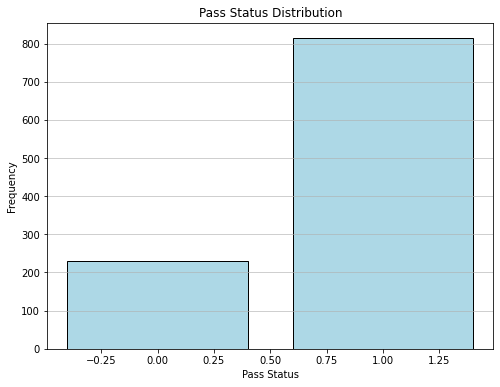

+----------+-----+----------+
|passstatus|count|Percentage|
+----------+-----+----------+
|         1|  814|     77.97|
|         0|  230|     22.03|
+----------+-----+----------+



In [17]:
# Create a histogram for the distribution of 'passstatus'
passstatus_histogram = student_data.groupBy("passstatus").count().orderBy("passstatus")
passstatus_levels = passstatus_histogram.rdd.map(lambda x: x[0]).collect()
passstatus_counts = passstatus_histogram.rdd.map(lambda x: x[1]).collect()

plt.figure(figsize=(8, 6))
plt.bar(passstatus_levels, passstatus_counts, color='lightblue', edgecolor='black')
plt.xlabel('Pass Status')
plt.ylabel('Frequency')
plt.title('Pass Status Distribution')
plt.grid(axis='y', alpha=0.75)

# Show the plot
plt.show()

# Generate a count and percentage table for 'passstatus'
passstatus_counts = student_data.groupBy("passstatus").count()
total_count = student_data.count()
passstatus_percentages = passstatus_counts.withColumn("Percentage", round(passstatus_counts["count"] / total_count * 100, 2))

# Show the count and percentage table
passstatus_percentages.show()

In [35]:
# Split the dataset into training and testing sets
X = student_data.drop('passstatus')
y = student_data.select('passstatus')

train_data, test_data = student_data.randomSplit([0.7, 0.3], seed=111)

# Amend class imbalance of passstatus for the training dataset
df_major_train = train_data.filter(col("passstatus") == 1)
df_minor_train = train_data.filter(col("passstatus") == 0)

a_count = df_major_train.count()
b_count = df_minor_train.count()
ratio = a_count / b_count

df_minor_upsample_train = df_minor_train.sample(True, ratio, seed=183)

train_data_upsampled = df_major_train.unionAll(df_minor_upsample_train)
train_data_upsampled = train_data_upsampled.withColumn("passstatus", when(col("passstatus") == 1, 1).otherwise(0))

# Combine X_train and y_train for the training dataset
training_data = train_data_upsampled

# Calculate class counts and percentages for the training dataset
class_counts_train = training_data.groupBy("passstatus").count()
total_count_train = training_data.count()
class_percentages_train = class_counts_train.withColumn("Percentage", (class_counts_train["count"] / total_count_train * 100).cast(StringType()))

# Display the class distribution for the training dataset
class_percentages_train.show()



+----------+-----+------------------+
|passstatus|count|        Percentage|
+----------+-----+------------------+
|         1|  476|51.182795698924735|
|         0|  454|48.817204301075265|
+----------+-----+------------------+



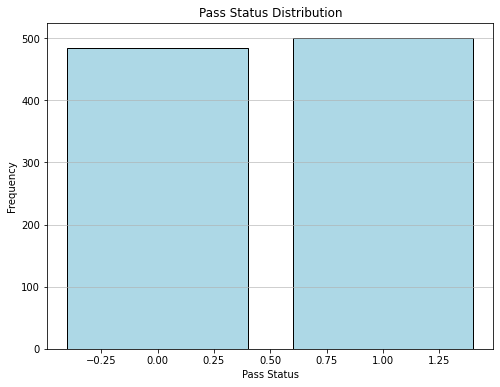

+----------+-----+----------+
|passstatus|count|Percentage|
+----------+-----+----------+
|         1|  500|     50.81|
|         0|  484|     49.19|
+----------+-----+----------+



The shape of data is: (984,30)


In [19]:
# Create a histogram for the distribution of 'passstatus'
passstatus_histogram = training_data.groupBy("passstatus").count().orderBy("passstatus")
passstatus_levels = passstatus_histogram.rdd.map(lambda x: x[0]).collect()
passstatus_counts = passstatus_histogram.rdd.map(lambda x: x[1]).collect()

plt.figure(figsize=(8, 6))
plt.bar(passstatus_levels, passstatus_counts, color='lightblue', edgecolor='black')
plt.xlabel('Pass Status')
plt.ylabel('Frequency')
plt.title('Pass Status Distribution')
plt.grid(axis='y', alpha=0.75)

# Show the plot
plt.show()

# Generate a count and percentage table for 'passstatus'
passstatus_counts = training_data.groupBy("passstatus").count()
total_count = training_data.count()
passstatus_percentages = passstatus_counts.withColumn("Percentage", round(passstatus_counts["count"] / total_count * 100, 2))

# Show the count and percentage table
passstatus_percentages.show()
print("The shape of data is: ({0},{1})".format(training_data.count(),len(training_data.columns)))

# Data Mining Algorithm Selection Phase

In [36]:
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.classification import RandomForestClassifier, DecisionTreeClassifier, MultilayerPerceptronClassifier, LogisticRegression

# Assemble features into a single vector column
feature_columns = [col for col in training_data.columns if col != 'passstatus']
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
X_train_assembled = assembler.transform(training_data)
X_test_assembled = assembler.transform(test_data)

# Apply StandardScaler to the features
scaler = StandardScaler(inputCol="features", outputCol="scaled_features")
scaler_model = scaler.fit(X_train_assembled)
X_train_scaled = scaler_model.transform(X_train_assembled)
X_test_scaled = scaler_model.transform(X_test_assembled)

# Initialize classifiers with the feature and label columns
random_forest = RandomForestClassifier(labelCol="passstatus", featuresCol="scaled_features")
decision_tree = DecisionTreeClassifier(labelCol="passstatus", featuresCol="scaled_features")
logistic_regression = LogisticRegression(labelCol="passstatus", featuresCol="scaled_features")

# Train classifiers on the upsampled training set
random_forest_model = random_forest.fit(X_train_scaled)
decision_tree_model = decision_tree.fit(X_train_scaled)
logistic_regression_model = logistic_regression.fit(X_train_scaled)

# Predict on the training set
y_train_pred_rf = random_forest_model.transform(X_train_scaled)
y_train_pred_dt = decision_tree_model.transform(X_train_scaled)
y_train_pred_lr = logistic_regression_model.transform(X_train_scaled)

# Predict on the testing set
y_pred_rf = random_forest_model.transform(X_test_scaled)
y_pred_dt = decision_tree_model.transform(X_test_scaled)
y_pred_lr = logistic_regression_model.transform(X_test_scaled)

# Calculate accuracy for each classifier on the training data
correct_predictions_rf_train = y_train_pred_rf.filter(y_train_pred_rf['prediction'] == y_train_pred_rf['passstatus']).count()
correct_predictions_dt_train = y_train_pred_dt.filter(y_train_pred_dt['prediction'] == y_train_pred_dt['passstatus']).count()
correct_predictions_lr_train = y_train_pred_lr.filter(y_train_pred_lr['prediction'] == y_train_pred_lr['passstatus']).count()

total_predictions_train = y_train_pred_rf.count()  # Assuming all classifiers have the same number of predictions

accuracy_train_rf = correct_predictions_rf_train / total_predictions_train
accuracy_train_dt = correct_predictions_dt_train / total_predictions_train
accuracy_train_lr = correct_predictions_lr_train / total_predictions_train

# Calculate accuracy for each classifier on the testing data
correct_predictions_rf = y_pred_rf.filter(y_pred_rf['prediction'] == y_pred_rf['passstatus']).count()
correct_predictions_dt = y_pred_dt.filter(y_pred_dt['prediction'] == y_pred_dt['passstatus']).count()
correct_predictions_lr = y_pred_lr.filter(y_pred_lr['prediction'] == y_pred_lr['passstatus']).count()

total_predictions = y_pred_rf.count()  # Assuming all classifiers have the same number of predictions

accuracy_rf = correct_predictions_rf / total_predictions
accuracy_dt = correct_predictions_dt / total_predictions
accuracy_lr = correct_predictions_lr / total_predictions

# Create a dictionary to store algorithm performances on both training and testing data
algorithm_performances = {
    'Random Forest (Training)': accuracy_train_rf,
    'Decision Trees (Training)': accuracy_train_dt,
    'Logistic Regression (Training)': accuracy_train_lr,
    'Random Forest (Testing)': accuracy_rf,
    'Decision Trees (Testing)': accuracy_dt,
    'Logistic Regression (Testing)': accuracy_lr
}

# Rank algorithm performances on the testing set
sorted_performances = sorted(algorithm_performances.items(), key=lambda x: x[1], reverse=True)

# Print algorithm rankings and accuracy scores
print("Algorithm Performances:")
for algorithm, accuracy in sorted_performances:
    print(f"{algorithm}: {accuracy * 100:.2f}%")


Algorithm Performances:
Decision Trees (Training): 80.97%
Random Forest (Training): 79.14%
Random Forest (Testing): 76.31%
Logistic Regression (Training): 75.38%
Logistic Regression (Testing): 69.70%
Decision Trees (Testing): 63.10%


In [21]:
from pyspark.ml.classification import RandomForestClassifier, DecisionTreeClassifier, LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.sql import functions as F

# Define your parameter grids for each model
rf_param_grid = {
    'numTrees': [50, 100, 200],
    'maxDepth': [None, 10, 20],
    'minInstancesPerNode': [1, 2, 4],
    'bootstrap': [True, False]
}

dt_param_grid = {
    'maxDepth': [None, 10, 20, 30, 40],
    'minInstancesPerNode': [1, 2, 4]
}

lr_param_grid = {
    'maxIter': [10, 20, 30],
    'regParam': [0.01, 0.1, 1.0],
    'elasticNetParam': [0.0, 0.5, 1.0]
}

# Create the models
rf_model = RandomForestClassifier(labelCol='passstatus', featuresCol='scaled_features')
dt_model = DecisionTreeClassifier(labelCol='passstatus', featuresCol='scaled_features')
lr_model = LogisticRegression(labelCol='passstatus', featuresCol='scaled_features')

from pyspark.ml import Pipeline

# Create a pipeline with the classifier
pipeline_rf = Pipeline(stages=[rf_model])

# Create the grid search
rf_grid_search = CrossValidator(estimator=pipeline_rf,
                                estimatorParamMaps=ParamGridBuilder().build(),
                                evaluator=MulticlassClassificationEvaluator(labelCol='passstatus'),
                                numFolds=3)

rf_grid_model = rf_grid_search.fit(X_train_scaled)
best_rf_model = rf_grid_model.bestModel.stages[0]

# Create a pipeline for Decision Tree
pipeline_dt = Pipeline(stages=[dt_model])
dt_grid_search = CrossValidator(estimator=pipeline_dt,
                                estimatorParamMaps=ParamGridBuilder().build(),
                                evaluator=MulticlassClassificationEvaluator(labelCol='passstatus'),
                                numFolds=3)

dt_grid_model = dt_grid_search.fit(X_train_scaled)
best_dt_model = dt_grid_model.bestModel.stages[0]

# Create a pipeline for Logistic Regression
pipeline_lr = Pipeline(stages=[lr_model])
lr_grid_search = CrossValidator(estimator=pipeline_lr,
                                estimatorParamMaps=ParamGridBuilder().build(),
                                evaluator=MulticlassClassificationEvaluator(labelCol='passstatus'),
                                numFolds=3)

lr_grid_model = lr_grid_search.fit(X_train_scaled)
best_lr_model = lr_grid_model.bestModel.stages[0]

# Function to convert param maps to a dictionary for readability
def param_map_to_dict(param_map):
    param_dict = {}
    for param, value in param_map.items():
        param_dict[param.name] = value
    return param_dict

# Output the best parameters for each algorithm
print("Random Forest Best Parameters:", param_map_to_dict(best_rf_model.extractParamMap()))
print("\nDecision Tree Best Parameters:", param_map_to_dict(best_dt_model.extractParamMap()))
print("\nLogistic Regression Best Parameters:", param_map_to_dict(best_lr_model.extractParamMap()))


Random Forest Best Parameters: {'bootstrap': True, 'cacheNodeIds': False, 'checkpointInterval': 10, 'featureSubsetStrategy': 'auto', 'featuresCol': 'scaled_features', 'impurity': 'gini', 'labelCol': 'passstatus', 'leafCol': '', 'maxBins': 32, 'maxDepth': 5, 'maxMemoryInMB': 256, 'minInfoGain': 0.0, 'minInstancesPerNode': 1, 'minWeightFractionPerNode': 0.0, 'numTrees': 20, 'predictionCol': 'prediction', 'probabilityCol': 'probability', 'rawPredictionCol': 'rawPrediction', 'seed': 9130457797077077732, 'subsamplingRate': 1.0}

Decision Tree Best Parameters: {'cacheNodeIds': False, 'checkpointInterval': 10, 'featuresCol': 'scaled_features', 'impurity': 'gini', 'labelCol': 'passstatus', 'leafCol': '', 'maxBins': 32, 'maxDepth': 5, 'maxMemoryInMB': 256, 'minInfoGain': 0.0, 'minInstancesPerNode': 1, 'minWeightFractionPerNode': 0.0, 'predictionCol': 'prediction', 'probabilityCol': 'probability', 'rawPredictionCol': 'rawPrediction', 'seed': -3909032010937650055}

Logistic Regression Best Parame

In [34]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Initialize the evaluator
evaluator = MulticlassClassificationEvaluator(labelCol="passstatus", predictionCol="prediction")

# Calculate metrics for the testing data
accuracy = evaluator.evaluate(y_pred_rf, {evaluator.metricName: "accuracy"})
f1_rf = evaluator.evaluate(y_pred_rf, {evaluator.metricName: "f1"})
precision_rf = evaluator.evaluate(y_pred_rf, {evaluator.metricName: "weightedPrecision"})
recall_rf = evaluator.evaluate(y_pred_rf, {evaluator.metricName: "weightedRecall"})

# Repeat for Decision Trees
accuracy_dt = evaluator.evaluate(y_pred_dt, {evaluator.metricName: "accuracy"})
f1_dt = evaluator.evaluate(y_pred_dt, {evaluator.metricName: "f1"})
precision_dt = evaluator.evaluate(y_pred_dt, {evaluator.metricName: "weightedPrecision"})
recall_dt = evaluator.evaluate(y_pred_dt, {evaluator.metricName: "weightedRecall"})

# Repeat for Logistic Regression
accuracy_lr = evaluator.evaluate(y_pred_lr, {evaluator.metricName: "accuracy"})
f1_lr = evaluator.evaluate(y_pred_lr, {evaluator.metricName: "f1"})
precision_lr = evaluator.evaluate(y_pred_lr, {evaluator.metricName: "weightedPrecision"})
recall_lr = evaluator.evaluate(y_pred_lr, {evaluator.metricName: "weightedRecall"})

# Define a function to format the metrics as percentages with two decimal places
def format_percentage(metric):
    return f"{metric * 100:.2f}%"

# Print the evaluation metrics as percentages
print("Random Forest Metrics:")
print("Accuracy:", format_percentage(accuracy))
print("F1-Score:", format_percentage(f1_rf))
print("Precision:", format_percentage(precision_rf))
print("Recall:", format_percentage(recall_rf))

print("\nDecision Trees Metrics:")
print("Accuracy:", format_percentage(accuracy_dt))
print("F1-Score:", format_percentage(f1_dt))
print("Precision:", format_percentage(precision_dt))
print("Recall:", format_percentage(recall_dt))

print("\nLogistic Regression Metrics:")
print("Accuracy:", format_percentage(accuracy_lr))
print("F1-Score:", format_percentage(f1_lr))
print("Precision:", format_percentage(precision_lr))
print("Recall:", format_percentage(recall_lr))


Random Forest Metrics:
Accuracy: 77.22%
F1-Score: 76.30%
Precision: 75.73%
Recall: 77.22%

Decision Trees Metrics:
Accuracy: 71.07%
F1-Score: 71.49%
Precision: 71.97%
Recall: 71.07%

Logistic Regression Metrics:
Accuracy: 67.65%
F1-Score: 69.47%
Precision: 72.63%
Recall: 67.65%


# Data Mining Phase

In [23]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics, BinaryClassificationMetrics
from sklearn.metrics import roc_curve, auc

# Function to plot ROC curve
def plot_roc_curve(fpr, tpr, auc, model_name):
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'{model_name} (AUC = {auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {model_name}')
    plt.legend(loc='lower right')
    plt.show()

# Function to plot confusion matrix
def plot_confusion_matrix_custom(y_true, y_pred, model_name):
    # Create a list of tuples containing true and predicted labels
    y_true_pred = list(zip(y_true, y_pred))

    # Convert the list to an RDD
    y_true_pred_rdd = spark.sparkContext.parallelize(y_true_pred)

    # Define the function to convert the RDD to a format suitable for MulticlassMetrics
    def convert_to_metrics_format(item):
        return (item[0], item[1])

    # Apply the conversion function
    cm = y_true_pred_rdd.map(convert_to_metrics_format)

    # Calculate the confusion matrix
    cm = MulticlassMetrics(cm).confusionMatrix().toArray()

    # Plot the confusion matrix
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix for {model_name}')
    plt.colorbar()
    classes = [0, 1]
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    # Add numbers in the cells
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, int(cm[i, j]),
                     ha="center", va="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

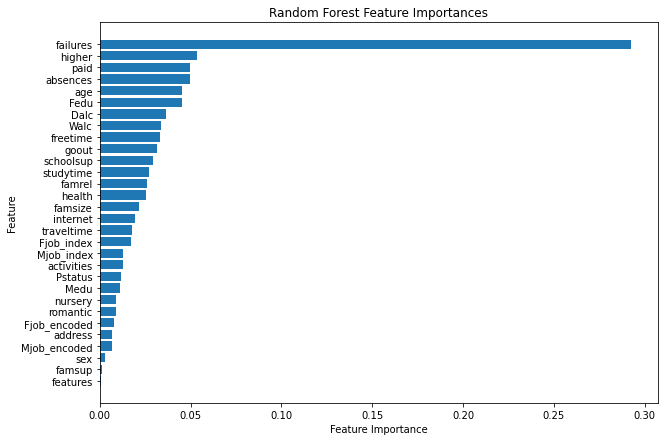

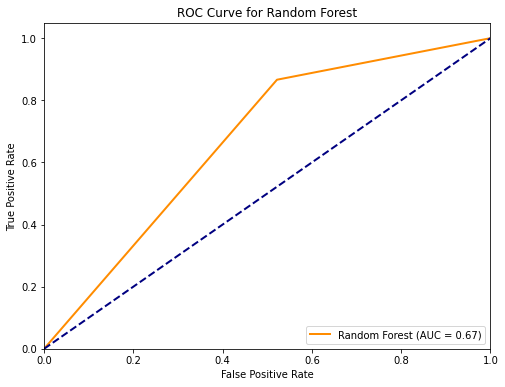

/home/ubuntu/spark-3.2.1-bin-hadoop2.7/python/pyspark/sql/context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


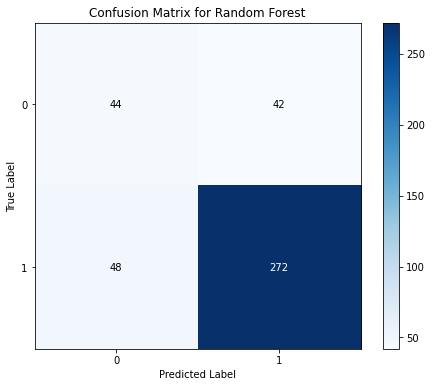

In [24]:
# Visualize Random Forest Feature Importance
rf_predictions = best_rf_model.transform(X_test_scaled)
y_test_rf = rf_predictions.select("passstatus").rdd.map(lambda x: x[0]).collect()
y_pred_rf = rf_predictions.select("prediction").rdd.map(lambda x: x[0]).collect()

# Extract feature importances from the Random Forest model
feature_importances = best_rf_model.featureImportances

# Get the list of feature names (assuming you have it)
feature_names = [col for col in X_test_assembled.columns if col != "passstatus"]

# Create a dictionary that maps feature names to their importances
feature_importance_dict = dict(zip(feature_names, feature_importances))

# Sort the feature importances in descending order
sorted_feature_importances = sorted(feature_importance_dict.items(), key=lambda x: x[1])

plt.figure(figsize=(10, 7))
sorted_feature_names, sorted_importances = zip(*sorted_feature_importances)
plt.barh(sorted_feature_names, sorted_importances)
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Random Forest Feature Importances')
plt.show()

# Plot ROC curve for Random Forest

false_positive_rate_rf, true_positive_rate_rf, thresholds_rf = roc_curve(y_test_rf, y_pred_rf)
roc_auc_rf = auc(false_positive_rate_rf, true_positive_rate_rf)
plot_roc_curve(false_positive_rate_rf, true_positive_rate_rf, roc_auc_rf, 'Random Forest')

# Plot confusion matrix for Random Forest
y_test_rf = rf_predictions.select("passstatus").rdd.map(lambda x: float(x[0])).collect()
y_pred_rf = rf_predictions.select("prediction").rdd.map(lambda x: float(x[0])).collect()
plot_confusion_matrix_custom(y_test_rf, y_pred_rf, 'Random Forest')

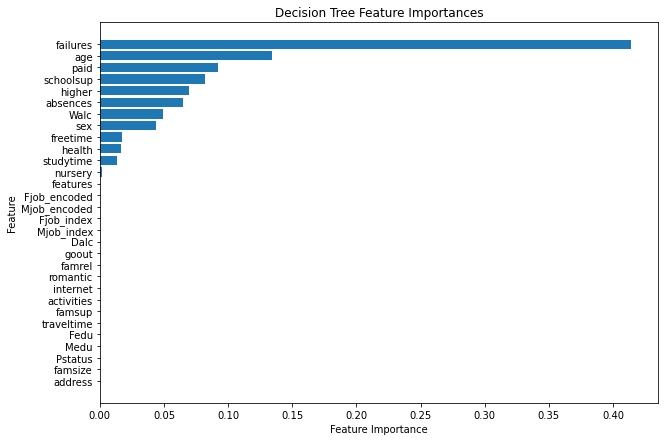

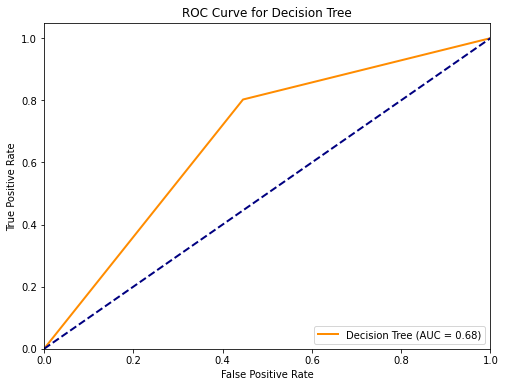

/home/ubuntu/spark-3.2.1-bin-hadoop2.7/python/pyspark/sql/context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


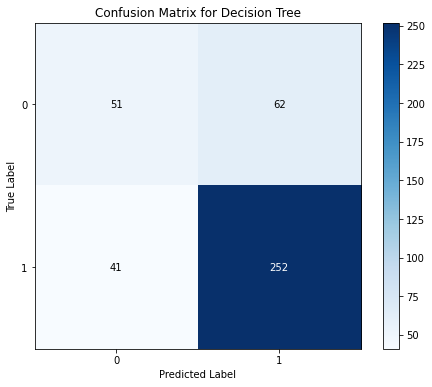

In [25]:
# Visualize Decision Tree Feature Importance
dt_predictions = best_dt_model.transform(X_test_scaled)
y_test_dt = dt_predictions.select("passstatus").rdd.map(lambda x: x[0]).collect()
y_pred_dt = dt_predictions.select("prediction").rdd.map(lambda x: x[0]).collect()

# Extract feature importances from the Decision Tree model
feature_importances = best_dt_model.featureImportances

# Get the list of feature names (assuming you have it)
feature_names = [col for col in X_test_assembled.columns if col != "passstatus"]

# Create a dictionary that maps feature names to their importances
feature_importance_dict = dict(zip(feature_names, feature_importances))

# Sort the feature importances in descending order
sorted_feature_importances = sorted(feature_importance_dict.items(), key=lambda x: x[1])

plt.figure(figsize=(10, 7))
sorted_feature_names, sorted_importances = zip(*sorted_feature_importances)
plt.barh(sorted_feature_names, sorted_importances)
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Decision Tree Feature Importances')
plt.show()

# Plot ROC curve for Decision Tree
false_positive_rate_dt, true_positive_rate_dt, thresholds_dt = roc_curve(y_test_dt, y_pred_dt)
roc_auc_dt = auc(false_positive_rate_dt, true_positive_rate_dt)
plot_roc_curve(false_positive_rate_dt, true_positive_rate_dt, roc_auc_dt, 'Decision Tree')

# Plot confusion matrix for Decision Tree
y_test_dt = dt_predictions.select("passstatus").rdd.map(lambda x: float(x[0])).collect()
y_pred_dt = dt_predictions.select("prediction").rdd.map(lambda x: float(x[0])).collect()
plot_confusion_matrix_custom(y_test_dt, y_pred_dt, 'Decision Tree')


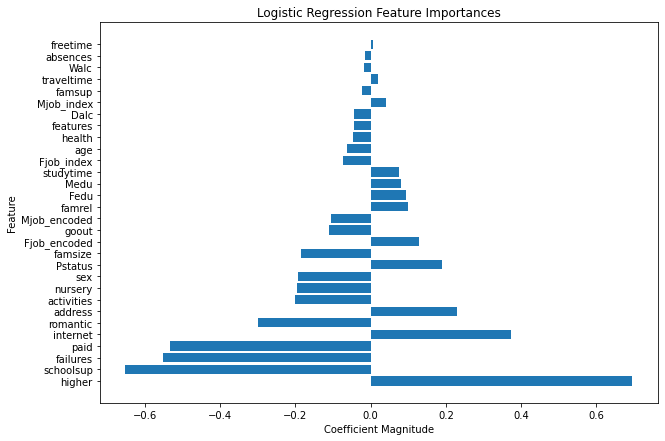

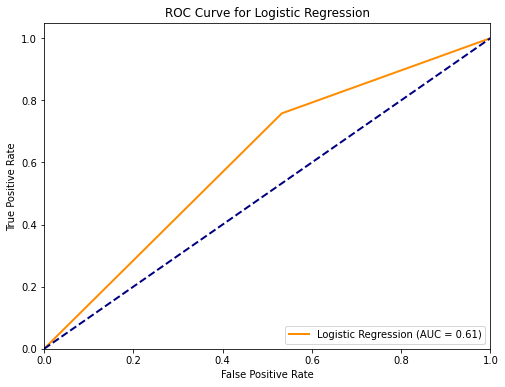

/home/ubuntu/spark-3.2.1-bin-hadoop2.7/python/pyspark/sql/context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


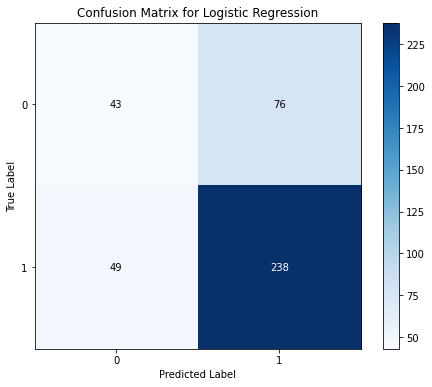

In [26]:
# Visualize Logistic Regression Feature Importances
lr = LogisticRegression(labelCol="passstatus", featuresCol="features", fitIntercept=True, regParam=0.1, elasticNetParam=0)
model_lr = lr.fit(X_train_assembled)

# Extract feature coefficients from the model
lr_coefficients = model_lr.coefficients

# Get the list of feature names excluding "passstatus"
feature_names = [col for col in X_test_assembled.columns if col != "passstatus"]

# Create a dictionary that maps feature names to their coefficients
feature_coefficients_dict = dict(zip(feature_names, lr_coefficients))

# Sort the feature coefficients in descending order
sorted_feature_coefficients = sorted(feature_coefficients_dict.items(), key=lambda x: abs(x[1]), reverse=True)

plt.figure(figsize=(10, 7))
plt.barh(*zip(*sorted_feature_coefficients))
plt.xlabel('Coefficient Magnitude')
plt.ylabel('Feature')
plt.title('Logistic Regression Feature Importances')
plt.show()

# Make predictions on the test set
lr_predictions = logistic_regression_model.transform(X_test_scaled)
y_test_lr = lr_predictions.select("passstatus").rdd.map(lambda x: x[0]).collect()
y_pred_lr = lr_predictions.select("prediction").rdd.map(lambda x: x[0]).collect()

# Calculate the ROC curve and AUC
false_positive_rate_lr, true_positive_rate_lr, _ = roc_curve(y_test_lr, y_pred_lr)
roc_auc_lr = auc(false_positive_rate_lr, true_positive_rate_lr)

# Plot the ROC curve
plot_roc_curve(false_positive_rate_lr, true_positive_rate_lr, roc_auc_lr, 'Logistic Regression')

# Plot the confusion matrix
y_test_lr = lr_predictions.select("passstatus").rdd.map(lambda x: float(x[0])).collect()
y_pred_lr = lr_predictions.select("prediction").rdd.map(lambda x: float(x[0])).collect()
plot_confusion_matrix_custom(y_test_lr, y_pred_lr, 'Logistic Regression')

In [27]:
# Print table output and shape
print("The shape of the data is: ({0},{1})".format(training_data.count(),len(student_por.columns)))
training_data.printSchema()
print(training_data.toPandas())

The shape of the data is: (984,31)
root
 |-- sex: integer (nullable = true)
 |-- age: integer (nullable = true)
 |-- address: integer (nullable = true)
 |-- famsize: integer (nullable = true)
 |-- Pstatus: integer (nullable = true)
 |-- Medu: integer (nullable = true)
 |-- Fedu: integer (nullable = true)
 |-- traveltime: integer (nullable = true)
 |-- studytime: integer (nullable = true)
 |-- failures: integer (nullable = true)
 |-- schoolsup: integer (nullable = true)
 |-- famsup: integer (nullable = true)
 |-- paid: integer (nullable = true)
 |-- activities: integer (nullable = true)
 |-- nursery: integer (nullable = true)
 |-- higher: integer (nullable = true)
 |-- internet: integer (nullable = true)
 |-- romantic: integer (nullable = true)
 |-- famrel: integer (nullable = true)
 |-- freetime: integer (nullable = true)
 |-- goout: integer (nullable = true)
 |-- Dalc: integer (nullable = true)
 |-- Walc: integer (nullable = true)
 |-- health: integer (nullable = true)
 |-- absences: 

     sex  age  address  famsize  Pstatus  Medu  Fedu  traveltime  studytime  \
0      0   15        0        0        0     1     1           1          2   
1      0   15        0        0        0     4     2           1          2   
2      0   15        0        0        1     2     1           2          1   
3      0   15        0        0        1     3     4           1          2   
4      0   15        0        0        1     4     3           1          2   
..   ...  ...      ...      ...      ...   ...   ...         ...        ...   
979    1   20        0        0        1     2     2           1          2   
980    1   20        0        0        1     2     2           1          2   
981    1   22        0        1        0     3     1           1          1   
982    1   22        0        1        0     3     1           1          1   
983    1   22        0        1        0     3     1           1          1   

     failures  ...  goout  Dalc  Walc  health  abse